In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *
from crystalcluster import CrystalCluster

sys.path.append('../3_score/')
from optimize import Scores

pdbbind_combo/P28523, 1M2R: 18 ligs, 18 docked ligs, 17 ligs docked well.


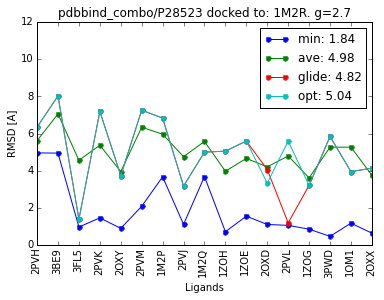

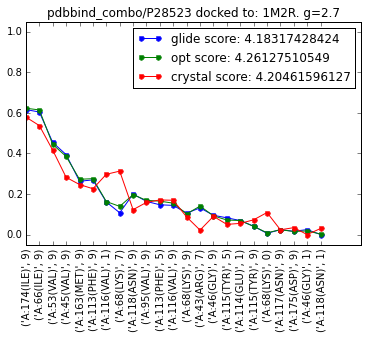

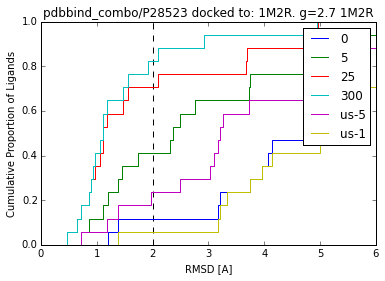

1M2R performance:
| u-1-ave | g-1-ave | u-1-suc | g-1-suc | u-1-med | g-1-med | u-5-ave | g-5-ave | u-5-suc | g-5-suc | u-5-med | g-5-med | 
| 5.04 | 4.82 | 1 | 2 | 5.05 | 5.0 | 3.69 | 3.39 | 4 | 5 | 3.21 | 2.87 | 
pdbbind_combo/P28523, 1M2Q: 18 ligs, 18 docked ligs, 17 ligs docked well.


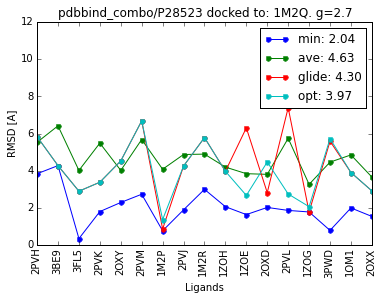

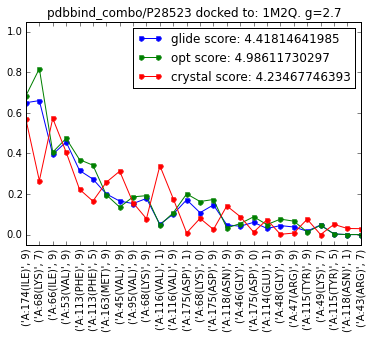

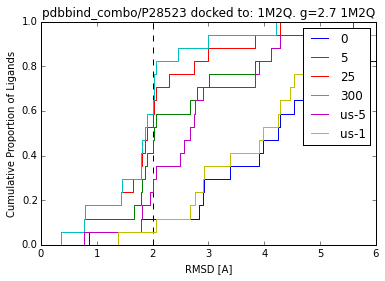

1M2Q performance:
| u-1-ave | g-1-ave | u-1-suc | g-1-suc | u-1-med | g-1-med | u-5-ave | g-5-ave | u-5-suc | g-5-suc | u-5-med | g-5-med | 
| 3.97 | 4.30 | 1 | 2 | 3.97 | 4.25 | 2.83 | 2.91 | 4 | 6 | 2.67 | 2.06 | 


In [2]:
get_ipython().magic(u'matplotlib inline')

all_scores = {}

u_lig = lambda x:len(os.listdir('/scratch/PI/rondror/docking_data/{}/final_ligands'.format(x)))
all_datasets = ['pdbbind_combo/{}'.format(s) for s in os.listdir('/scratch/PI/rondror/docking_data/pdbbind_combo')]
all_datasets.sort(key=lambda x: u_lig(x))
all_datasets = list(filter(lambda x: u_lig(x) >= 15, all_datasets))

grids = {}
with open('/scratch/PI/rondror/docking_data/pdbbind_first_grids.txt') as f:
    for line in f:
        r, g = line.strip().split()
        grids['pdbbind_combo/'+r] = [g]
        
with open('/scratch/PI/rondror/docking_data/pdbbind_second_grids.txt') as f:
    for line in f:
        r, g = line.strip().split()
        grids['pdbbind_combo/'+r].append(g)

all_datasets = ['pdbbind_combo/P28523']
        
for receptor in all_datasets:
        
    all_scores[receptor] = {}
        
    g = 2.7
    for s in grids[receptor]:        
        (xcrystals, xglides) = load_data(receptor, s,
                                         w=[1,1,1,1,1,0.5,1,1,1,0.02,0,0,0],
                                         #w=[10,10,0,0,10,5,10,10,10,0,0,0,0],
                                         glide_ifp='xglide9', crystal_ifp='xcrystal9')
        
        ligs = xglides.keys()
        #print receptor, s, u_lig[receptor]
        
        best_rmsds = [np.min([xglides[l].poses[p].rmsd for p in range(min(25, len(xglides[l].poses.keys())))]) for l in ligs]
        #assert len(best_rmsds) == len(ligs)
        filt_lig = [l for i, l in enumerate(ligs) if l != s]# and best_rmsds[i] <= 2]
        
        print '{}, {}: {} ligs, {} docked ligs, {} ligs docked well.'.format(receptor, s, len(xcrystals), len(xglides), len(filt_lig))
        
        #if len(filt_lig) < 10: continue
        
        all_scores[receptor][s] = Scores(xglides, xcrystals, filt_lig, s, 25, gscore_weight=g)
        title = '{} docked to: {}. g={}'.format(receptor, s, g)
        final_rmsds = plot_final_rmsds(all_scores[receptor][s], title)

        plot_shared_interactions(all_scores[receptor][s], max_r=20, title=title)
        
        plot_docking_by_structure(filt_lig, s, xglides, n_list=[0,5,25,300], title=title, scores=all_scores[receptor][s])
        print s, 'performance:'
        print_table(all_scores[receptor][s])

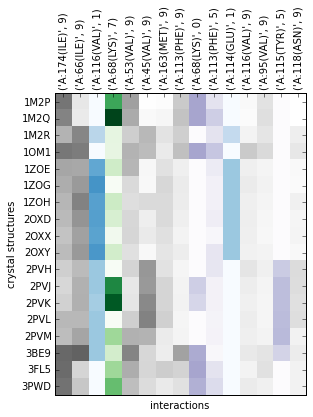

In [3]:
cc = CrystalCluster(xcrystals, 1, [i for i in range(12)])
cc.show_clusters_together()
#ai, fp3d = cc.get_fp_vectors(xcrystals.keys())

In [ ]:
for l in sorted(xcrystals.keys()):
    print l
    if 'A:116(VAL)' in xcrystals[l]:
        print xcrystals[l]['A:116(VAL)'][:4]
    #reak

In [ ]:
u_lig = lambda x:len(os.listdir('/scratch/PI/rondror/docking_data/{}/final_ligands'.format(x)))
all_datasets = ['pdbbind_combo/{}'.format(s) for s in os.listdir('/scratch/PI/rondror/docking_data/pdbbind_combo')]
all_datasets.sort(key=lambda x: u_lig(x))
all_datasets = list(filter(lambda x: u_lig(x) >= 15, all_datasets))

grids = {}
with open('/scratch/PI/rondror/docking_data/pdbbind_first_grids.txt') as f:
    for line in f:
        r, g = line.strip().split()
        grids['pdbbind_combo/'+r] = [g]
        
with open('/scratch/PI/rondror/docking_data/pdbbind_second_grids.txt') as f:
    for line in f:
        r, g = line.strip().split()
        grids['pdbbind_combo/'+r].append(g)

all_loaded_data = {r:{} for r in all_datasets}
        
for receptor in all_datasets:
    for i, s in enumerate(grids[receptor]):
        (xcrystals, xglides) = load_data(receptor, s,
                                         w=[0,0,10,10,10,5,10,10,10,0.2,0,0,0],
                                         glide_ifp='xglide8', crystal_ifp='xcrystal8')
        if i == 0:
            all_loaded_data[receptor]['xcrystals'] = xcrystals
        all_loaded_data[receptor][s] = xglides

In [ ]:
get_ipython().magic(u'matplotlib inline')

all_dock = {r:{} for r in all_datasets}
        
for receptor in all_datasets:
        
    #all_dock[receptor] = {'good':[], 'total':u_lig(receptor) - 1}
    for s in grids[receptor]:        
        xglides = all_loaded_data[receptor][s]
        
        best_rmsds = {}
        for n in [1,5,25,300]:
            best_rmsds[n] = [np.min([xglides[l].poses[p].rmsd for p in range(min(n, len(xglides[l].poses)))]) for l in xglides]
        
        #filt_lig = [l for i, l in enumerate(ligs) if l != s and best_rmsds[i] <= 2]
        all_dock[receptor][s] = best_rmsds#['good'].append(len(filt_lig))
        
        #print '{}, {}: {} ligs, {} docked ligs, {} ligs docked well.'.format(receptor, s, len(xcrystals), len(xglides), len(filt_lig))

In [ ]:
fig, ax = plt.subplots()
symb = ['.','*','d','s']
for i,r in enumerate(reversed(all_datasets)):
    s1, s2 = success(all_dock[r][grids[r][0]][25]), success(all_dock[r][grids[r][1]][25])
    tot = float(len(all_dock[r][grids[r][0]][1]))
    plt.plot([s1/tot], [s2/tot], symb[i%len(symb)], markersize=8, label=r.split('/')[-1])
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=3)
plt.xlabel('structure 1')
plt.ylabel('structure 2')
plt.title('glide: fraction of ligands with a good pose in the top 25')
ax.set_aspect('equal')#abs(x1-x0)/abs(y1-y0))
plt.show()

In [ ]:
get_ipython().magic(u'matplotlib inline')

success = lambda x: float(sum([1 for i in x if i <= 2]))

fig, ax = plt.subplots()
symb = ['.','*','d','s']
for i,r in enumerate(reversed(all_datasets)):
    for s in grids[r]:
        tot_success = float(len(all_dock[r][s][25]))#success(all_dock[r][s][25])
        if tot_success == 0.0: continue
        plt.plot([success(all_dock[r][s][300])/tot_success],[success(all_dock[r][s][25])/tot_success], 
                 symb[i%len(symb)], markersize=8, label='{}: {}'.format(r.split('/')[-1], s))
        #s1, s2 = all_dock[r]['good']
        #tot = float(all_dock[r]['total'])
        #print r, s1, s2, tot
        #break
        #plt.plot([s1], [s2], symb[i%len(symb)], markersize=8, label=r.split('/')[-1])
        #plt.plot([s1], [s2], symb[i%len(symb)], markersize=8, label=r.split('/')[-1])
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)
plt.xlabel('top-300 success rate')
plt.ylabel('top-25 success rate')
plt.title('glide performance on all ligands')
ax.set_aspect('equal')#abs(x1-x0)/abs(y1-y0))
plt.show()

In [ ]:
print isinstance(xglides['1GI7'], Ligand)
#print xglides['1GI7'].poses
#print ligs
#print best_rmsds
#print [xglides['1GI7'].poses[p].rmsd for p in range(25)]
print xcrystals['1GI7']

In [ ]:
all_all_analysis = {}

In [ ]:
all_all_analysis[receptor] = a

In [ ]:
print len(all_all_analysis.keys())

In [ ]:
metrics = {}
for r in all_all_analysis.keys():
    metrics[r] = {'us':{},'glide':{}}
    metrics[r]['us']['mean'] = np.mean(all_all_analysis[r]['opt'][1][:])
    metrics[r]['glide']['mean'] = np.mean(all_all_analysis[r]['glide'][1][:])
    metrics[r]['us']['med'] = np.median(all_all_analysis[r]['opt'][1][:])
    metrics[r]['glide']['med'] = np.median(all_all_analysis[r]['glide'][1][:])
    metrics[r]['us']['success'] = sum([1 for i in all_all_analysis[r]['opt'][1] if i <= 2.0])
    metrics[r]['glide']['success'] = sum([1 for i in all_all_analysis[r]['glide'][1] if i <= 2.0])
    #metrics[r]['n'] = len(all_all_analysis[r]['opt'][1][:])

In [ ]:
get_ipython().magic(u'matplotlib inline')

bins = [5*i for i in range(-3, 25)]

plt.hist(sorted([100*metrics[r]['us']['success']/float(metrics[r]['glide']['success']) - 100
                 if metrics[r]['glide']['success'] != 0 else 1 for r in metrics]), bins)
plt.title('percent improvement in success rate (# ligands <= 2A)')
plt.ylabel('number of pdbbind datasets (20 total)')
plt.show()

plt.hist([metrics[r]['glide']['med'] - metrics[r]['us']['med'] for r in metrics], [0.2*i for i in range(0,18)])
plt.title('improvement in median rmsd [angstroms]')
plt.ylabel('# of pdbbind datasets (20 total)')
plt.show()

plt.hist([metrics[r]['glide']['mean'] - metrics[r]['us']['mean'] for r in metrics])
plt.title('absolute improvement in mean rmsd [angstroms]')
plt.ylabel('number of pdbbind datasets (20 total)')
plt.show()

In [ ]:
print len(all_final['glide'])